In [26]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [27]:
# 1. 데이터 로드 함수 정의

def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

# 전체 데이터셋 로드 함수
def load_dataset(prefix=''):
    dataset_path = '/content/drive/MyDrive/Colab Notebooks/기계학습프로그래밍/10주/UCI HAR Dataset/'
    # train/test 데이터 불러오기
    trainX, trainy = load_dataset_group('train', dataset_path)
    testX, testy = load_dataset_group('test', dataset_path)

    # 레이블 0부터 시작하도록 조정
    trainy = trainy - 1
    testy = testy - 1

    # 원-핫 인코딩
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)

    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

# 2. 데이터 불러오기 및 분할

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

X_train, X_val, y_train_one_hot, y_val_one_hot, y_train, y_val = train_test_split(
    trainX, trainy_one_hot, trainy,
    test_size=0.2,
    random_state=100
)

print(X_train.shape, X_val.shape, y_train_one_hot.shape, y_val_one_hot.shape)

/tmp/ipython-input-3726284836.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-3726284836.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-3726284836.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-3726284836.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)
(5881, 128, 9) (1471, 128, 9) (5881, 6) (1471, 6)


In [28]:
# 3. CNN 간소화 모델 정의

n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(n_outputs, activation='softmax')
])

cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_16 (Conv1D)              │ (None, 126, 64)        │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 61, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        61,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,862 (272.90 KB)

 Trainable params: 69,862 (272.90 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# 4. 학습

history = cnn_model.fit(
    X_train, y_train_one_hot,
    epochs=30,
    batch_size=64,
    validation_data=(X_val, y_val_one_hot),
    verbose=1
)

Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5120 - loss: 1.1642 - val_accuracy: 0.8069 - val_loss: 0.4797
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8383 - loss: 0.3931 - val_accuracy: 0.9048 - val_loss: 0.2734
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9148 - loss: 0.2244 - val_accuracy: 0.9205 - val_loss: 0.1886
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9306 - loss: 0.1695 - val_accuracy: 0.9429 - val_loss: 0.1683
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9467 - loss: 0.1333 - val_accuracy: 0.9395 - val_loss: 0.1451
Epoch 6/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9399 - loss: 0.1367 - val_accuracy: 0.9409 - val_loss: 0.1496
Epoch 7/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9457 - loss: 0.1337 - val_accuracy: 0.9443 - val_loss: 0.1441
Epoch 8/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9451 - loss: 0.1289 - val_accuracy: 0.9477 - v

In [30]:
# 5. 평가
# ============================================
loss, acc = cnn_model.evaluate(testX, testy_one_hot, verbose=0)
print(f'Test Accuracy: {acc:.4f}')

Test Accuracy: 0.9203


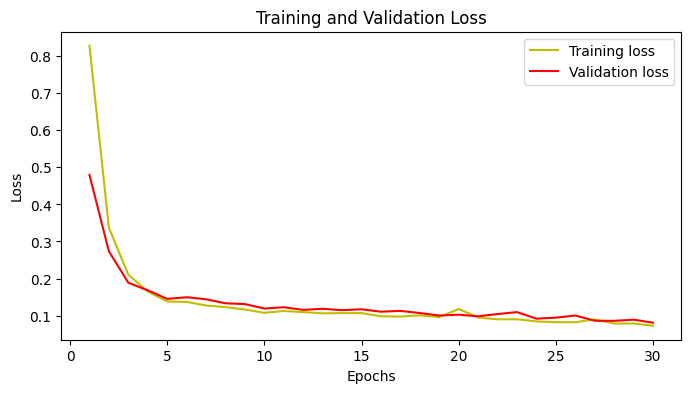

In [31]:
# 6. 학습 결과 시각화

import matplotlib.pyplot as plt
import seaborn as sns

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# 손실 그래프
plt.figure(figsize=(8, 4))
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

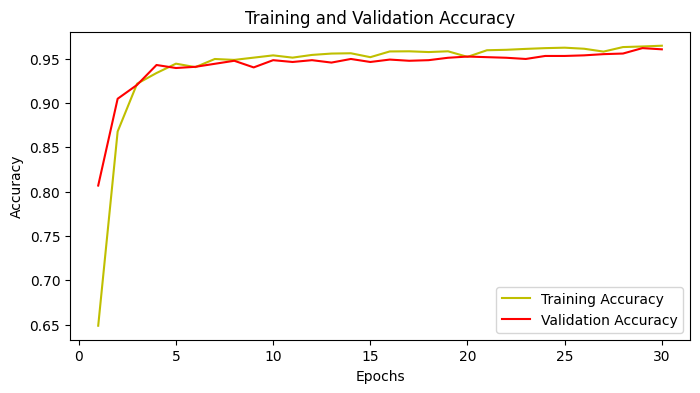

In [32]:
# 정확도 그래프

plt.figure(figsize=(8, 4))
plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
✅ Test Accuracy: 0.9202578893790295

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.97       496
           1       0.89      0.96      0.92       471
           2       0.96      0.99      0.97       420
           3       0.82      0.85      0.84       491
           4       0.87      0.83      0.85       532
           5       1.00      0.95      0.97       537

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947



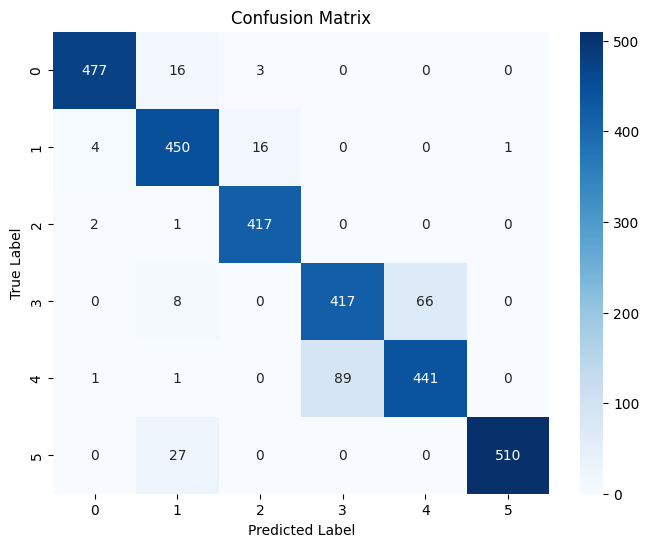

In [33]:
# 테스트셋 평가 및 예측
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# 예측 수행
pred = cnn_model.predict(testX)
pred = np.argmax(pred, axis=-1)

# 실제 정답 (one-hot → index로 변환)
true = np.argmax(testy_one_hot, axis=-1)

# 정확도 및 리포트 출력
print("✅ Test Accuracy:", accuracy_score(true, pred))
print("\n📊 Classification Report:\n", classification_report(true, pred))


# 혼동 행렬 시각화

cm = confusion_matrix(true, pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()